In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 300
plt.style.use("seaborn")

## First deep neural network

In [4]:
import tensorflow as tf
tf.__version__

'2.8.1'

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

NUM_CLASSES = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

170508288/170498071 [==============================] - 19s 0us/step


In [ ]:
x_train[54, 12, 13, 1]

はじめだけ Sequential モデルと functional API の2通りの書き方で記述するが、functional API での記述を推奨している

In [7]:
# create model with sequential model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential([
    Dense(200, activation="relu", input_shape=(32, 32, 3)),
    Flatten(),
    Dense(150, activation="relu"),
    Dense(NUM_CLASSES, activation="softmax"),
])


In [8]:
# create model with functional API

from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

input_layer = Input(shape=(32, 32, 3))

x = Flatten()(input_layer)

x = Dense(200, activation="relu")(x)
x = Dense(150, activation="relu")(x)

output_layer = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(input_layer, output_layer)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 200)               614600    
                                                                 
 dense_4 (Dense)             (None, 150)               30150     
                                                                 
 dense_5 (Dense)             (None, 10)                1510      
                                                                 
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


↑の Output Shape のはじめが None になっているのは、現時点でこのネットワークに渡させる観測データの数が Keras にはまだわからないから。

In [12]:
# compile model

from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

/Users/taikisato/miniforge3/envs/generative-deep-learning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# training model

model.fit(
    x_train,
    y_train,
    batch_size=32, # 各訓練ステップで何個の観測をこのネットワークに渡すか
    epochs=10, # このネットワークに何回全訓練データを渡すか
    shuffle=True, # 訓練データをシャッフルするか
)

Epoch 1/10


2022-06-02 12:58:08.869631: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1563/1563 [==============================] - 3s 2ms/step - loss: 2.0150 - accuracy: 0.2794
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.8466 - accuracy: 0.3265
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.8174 - accuracy: 0.3399
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7851 - accuracy: 0.3537
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7673 - accuracy: 0.3615
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7467 - accuracy: 0.3711
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7399 - accuracy: 0.3710
Epoch 8/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7353 - accuracy: 0.3740
Epoch 9/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7271 - accuracy: 0.3783
Epoch 10/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7246 - accurac

In [14]:

# evaluate model

model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 679us/step - loss: 1.7477 - accuracy: 0.3652


[1.7477437257766724, 0.365200012922287]

ランダムな推測(10クラス)の10%と比較すると良い結果

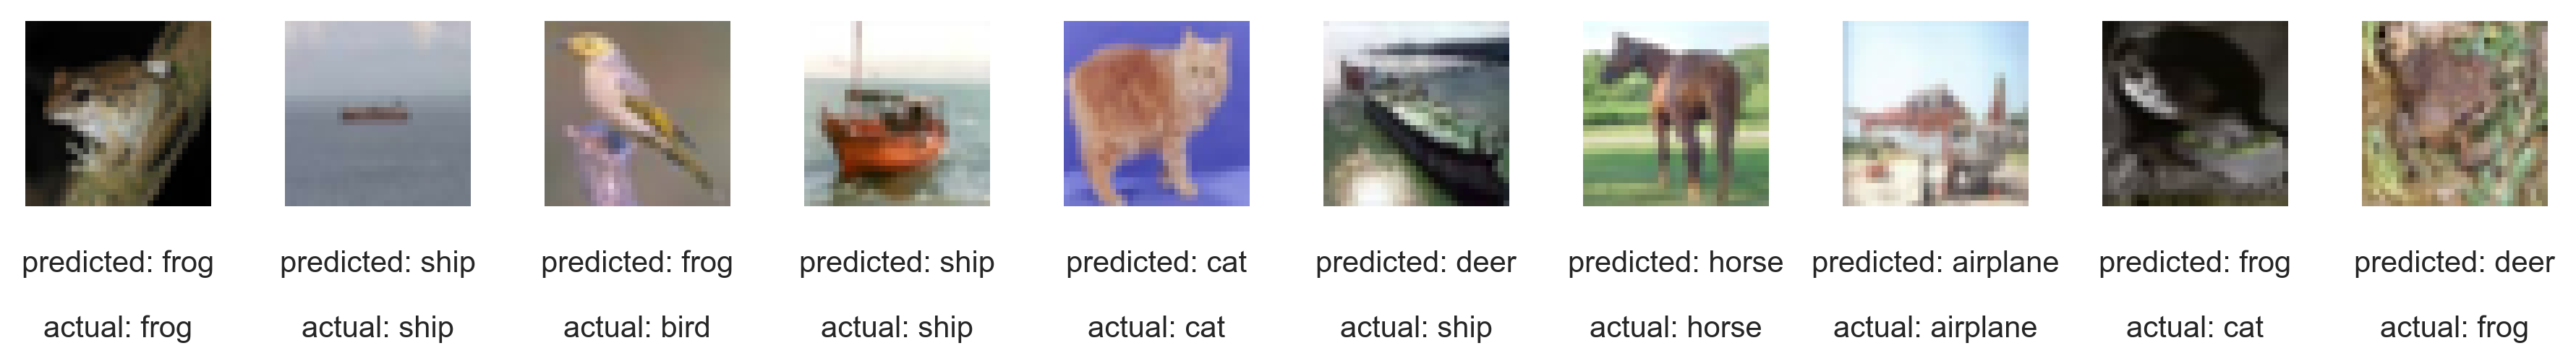

In [15]:
# analysis

CLASSES = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]


n_to_show = 10
indices = np.random.choice(x_test.shape[0], n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1, xticks=[], yticks=[])
    ax.axis("off")
    ax.text(0.5, -0.35, f"predicted: {preds_single[idx]}", fontsize=10, ha="center", transform=ax.transAxes)
    ax.text(0.5, -0.7, f"actual: {actual_single[idx]}", fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(img)


## improve model

- 現状のネットワークには入力画像の空間構造を考慮していない
  - 畳み込み層


In [17]:
# with Conv2D, BatchNormalization, Dropout

from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Activation, LeakyReLU

input_layer = Input(shape=(32, 32, 3))

x = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation("softmax")(x)

model = Model(input_layer, output_layer)


In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                           

In [19]:
# compile model

opt = Adam(lr=0.005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

/Users/taikisato/miniforge3/envs/generative-deep-learning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
# training model

model.fit(
    x_train,
    y_train,
    batch_size=32, # 各訓練ステップで何個の観測をこのネットワークに渡すか
    epochs=10, # このネットワークに何回全訓練データを渡すか
    shuffle=True, # 訓練データをシャッフルするか
)

Epoch 1/10
1563/1563 [==============================] - 41s 26ms/step - loss: 1.5450 - accuracy: 0.4487
Epoch 2/10
1563/1563 [==============================] - 42s 27ms/step - loss: 1.1656 - accuracy: 0.5877
Epoch 3/10
1563/1563 [==============================] - 38s 24ms/step - loss: 1.0225 - accuracy: 0.6398
Epoch 4/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.9485 - accuracy: 0.6681
Epoch 5/10
1563/1563 [==============================] - 43s 27ms/step - loss: 0.8913 - accuracy: 0.6880
Epoch 6/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.8517 - accuracy: 0.7016
Epoch 7/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.8070 - accuracy: 0.7188
Epoch 8/10
1563/1563 [==============================] - 41s 26ms/step - loss: 0.7703 - accuracy: 0.7303
Epoch 9/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.7435 - accuracy: 0.7409
Epoch 10/10
1563/1563 [==============================] - 37s 24m

In [21]:
# evaluate model

model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 1.0777 - accuracy: 0.6481


[1.0776787996292114, 0.6481000185012817]

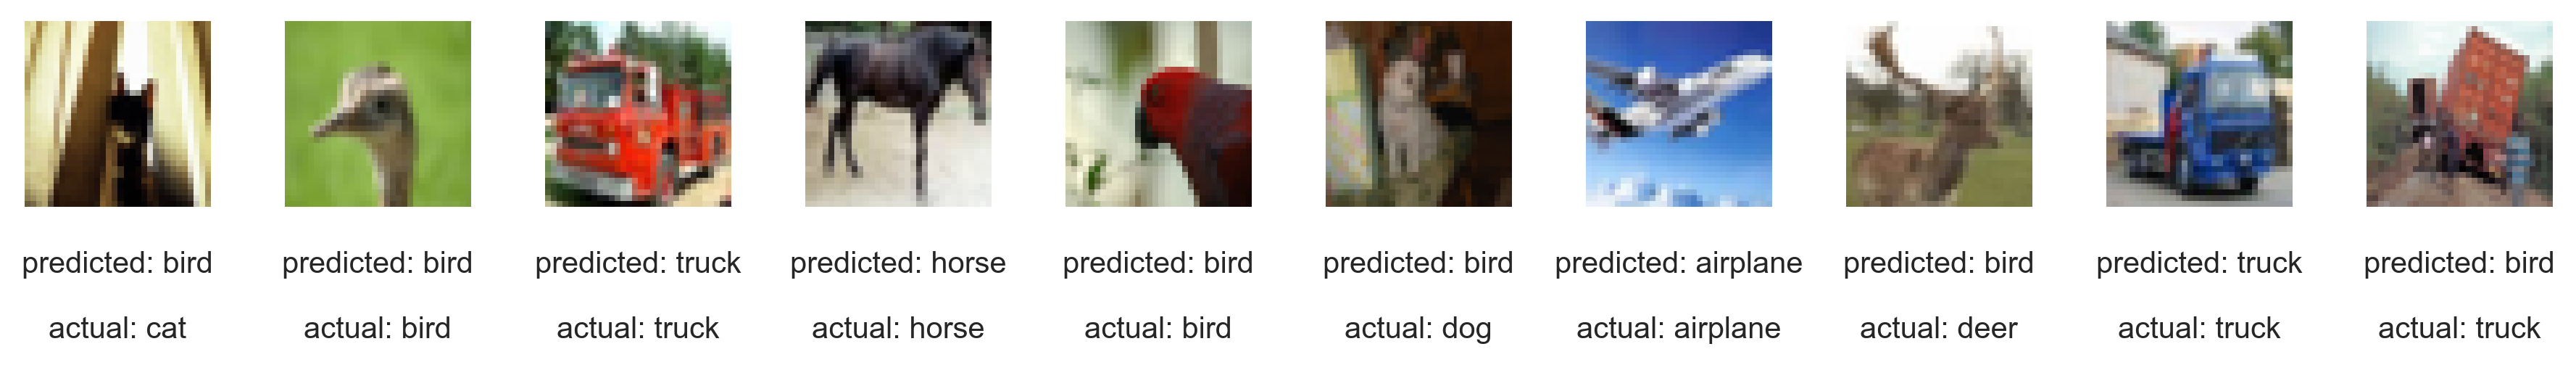

In [22]:
# analysis

CLASSES = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]


n_to_show = 10
indices = np.random.choice(x_test.shape[0], n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1, xticks=[], yticks=[])
    ax.axis("off")
    ax.text(0.5, -0.35, f"predicted: {preds_single[idx]}", fontsize=10, ha="center", transform=ax.transAxes)
    ax.text(0.5, -0.7, f"actual: {actual_single[idx]}", fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(img)
